# Project 5: Vehicle Detection
---
_Lorenzo's version_

Udacity Self-Driving Car nanodegree

The goals / steps of this project are the following:

1. Perform a **Histogram of Oriented Gradients (HOG) feature extraction** on a labeled training set of images and train a classifier Linear SVM classifier 
2. Optionally, apply a **color transform** and append **binned color features**, as well as **histograms of color**, to your HOG feature vector _Note: for these first two steps we will normalize the features and randomize a selection for training and testing._

3. Implement a **sliding-window technique** and use the above trained classifier to search for vehicles in images.
4. Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a **heat map of recurring detections** frame by frame to reject outliers and follow detected vehicles.
5. Estimate a **bounding box** for vehicles detected.

1. Dataset exploration
---
First, we load and look into our labeled dataset. It comes from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import numpy as np
from toolz import pipe
import cv2
%matplotlib inline

In [2]:
vehicle_images = glob.glob('data/vehicles/vehicles/**/*.png',recursive=True)
non_vehicle_images = glob.glob('data/non-vehicles/non-vehicles/**/*.png',recursive=True)

In [3]:
print('We have {} images of vehicles and {} non-vehicle images'.format(len(vehicle_images), len(non_vehicle_images)))

We have 8792 images of vehicles and 8968 non-vehicle images


In [4]:
random_img = random.choice(vehicle_images)
print('Images have the shape: {}'.format(mpimg.imread(random_img).shape))

Images have the shape: (64, 64, 3)


Let's create a simple helper function that will show images under various transformations.

In [5]:
def compare_images(num_images, list_images, output_func, input_func = lambda x: x, 
                   cmap_out=None, cmap_in=None, save_to='', row_size=(24,9)):  
    
    f, subs = plt.subplots(num_images, 2, figsize=(row_size[0], row_size[1]*num_images))
    #f.tight_layout()
    samples = random.sample(list_images, num_images)
    
    for idx, sample_image in enumerate(samples):        
        subs[idx,0].imshow(pipe(sample_image, plt.imread, input_func),cmap=cmap_in)
        subs[idx,0].set_title('Original Image', fontsize=12)
        subs[idx,1].imshow(pipe(sample_image, plt.imread, output_func),cmap=cmap_out)
        subs[idx,1].set_title('Transformed Image', fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    if save_to is not '':
        f.savefig(save_to)

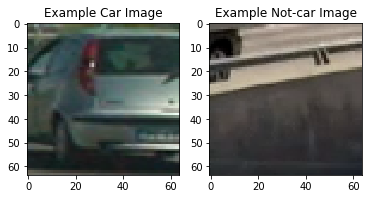

In [6]:
random_show = lambda imgs: pipe(imgs, random.choice, plt.imread, plt.imshow)
    
fig = plt.figure()
plt.subplot(121)
random_show(vehicle_images)
plt.title('Example Car Image')
plt.subplot(122)
random_show(non_vehicle_images)
plt.title('Example Not-car Image');

fig.savefig('car_not_car')

The data set looks balanced in terms of positive and negative examples.

Pipelining 
---
During this project, we will extensively use the `Pipeline` class from `sklearn.pipeline`. It is an elegant way to sequentially apply a list of transformers and fitters. Defined pipeline variable names will be prefixed by `p_`.

In [7]:
from sklearn.pipeline import Pipeline, TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer

In [8]:
class ImageReader(BaseEstimator, TransformerMixin):
    def __init__(self, input_filename=True, col_space='GRAY', channel_nb=0, img_format='I'):
        self.input_filename = input_filename
        self.col_space = col_space
        self.channel_nb = channel_nb if col_space is not 'GRAY' else None
        self.img_format = img_format
    
    def get_img(self, img):
        #import cv2         
        if self.input_filename: img = mpimg.imread(img, self.img_format)
        if self.col_space is not 'RGB': img = cv2.cvtColor( img, eval('cv2.COLOR_RGB2' + self.col_space) )
        return img[:,:,self.channel_nb] if self.channel_nb is not None else img
    
    def transform(self, x):
        return [self.get_img(f) for f in x] if type(x) is list else self.get_img(x)
    
    def fit(self, x, y=None):
        return self

In [9]:
p_read = Pipeline([
    ('read', ImageReader())
])

In [10]:
p_read.get_params();

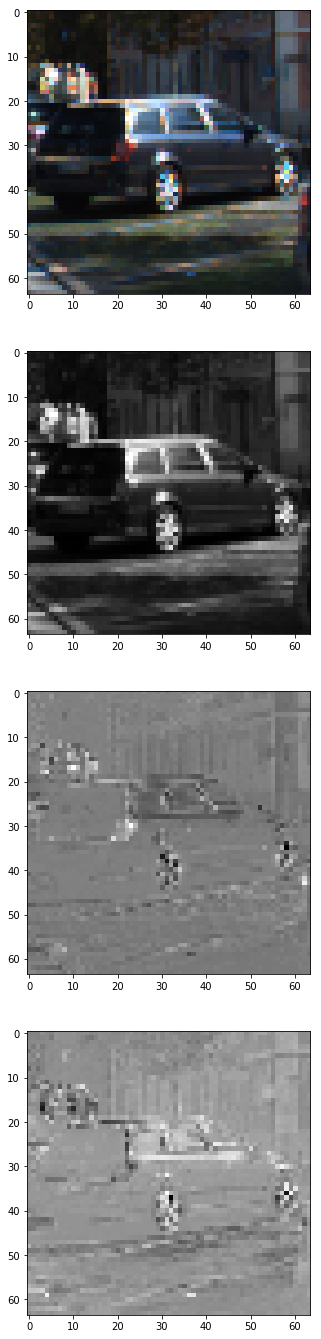

In [11]:
f, subs = plt.subplots(4, 1, figsize=(6,24))
img = random.choice(vehicle_images)
subs[0].imshow(plt.imread(img))
for channel in [0,1,2]:
    p_read.set_params(read__input_filename=True, read__col_space='YCrCb', read__channel_nb=channel)
    subs[channel+1].imshow(p_read.transform(img), cmap='gray')
f.savefig('YCrCb_decomposition')

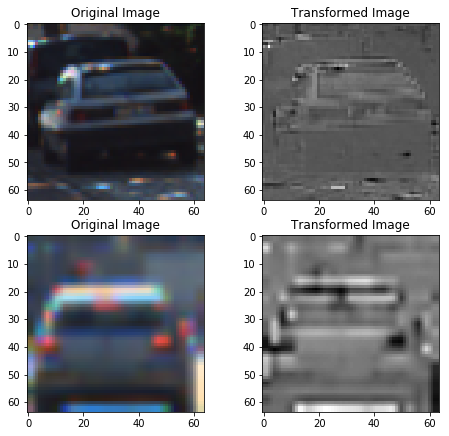

In [12]:
p_read.set_params(read__input_filename=False)
compare_images(2,vehicle_images,p_read.transform,cmap_out='gray',row_size=(6,3))

2. Features Extraction
---


### a. Histogram of Oriented Gradients (HOG) 
We will now extract from our images the HOG features. Parameters for this step are:
- image color channel (e.g. `RGB`, `HLS`, `HSV`, `YCrCB`, etc...)
- number of gradient orientations
- number of pixels per cell
- number of cells per block

For this task we simply define a `HOGFeatExtractor` class that will be part of our pipeline.

In [13]:
from skimage.feature import hog
from sklearn.externals.joblib import Parallel, delayed
# HOGFeatExtractor - takes an image as input and returns HOG Features
class HOGFeatExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, output_image=False, orient=9, pix_per_cell=8, cell_per_block=2, 
                 channel=None, features_vector=True, n_jobs=10):
        self.orient          = orient
        self.pix_per_cell    = pix_per_cell
        self.cell_per_block  = cell_per_block
        self.output_image    = output_image and channel is not None # For visualization purposes
        self.channel         = channel
        self.features_vector = features_vector
        self.n_jobs          = n_jobs
    
    def hog(self, x):
        out = hog(
            x, 
            orientations    = self.orient, 
            pixels_per_cell = (self.pix_per_cell, self.pix_per_cell), 
            cells_per_block = (self.cell_per_block, self.cell_per_block), 
            visualise       = self.output_image, 
            feature_vector  = self.features_vector
        )
        return out[1] if self.output_image else out
    
    def get_hog_features(self, image:np.ndarray):        
        if len(image.shape) == 3:
            hog_feats = [self.hog(image[:,:,x]) for x in range(image.shape[2])]
            output = np.concatenate(hog_feats) if self.features_vector else hog_feats            
        else:
            output = self.hog(image)
        return output
                          
    def transform(self, x):
        # Case when we just want to visualize the output
        if self.output_image:            
            return self.hog(x[:,:,self.channel])
        # Case when we train/test: multiple images (as list) and everything as features vector
        # Note: we call the skimage.hog function multiple times here, which could be pretty slow.
        # In order to address this, we parallelize this loop.
        if type(x) is list and self.features_vector:            
            return np.array(Parallel(n_jobs=self.n_jobs)(delayed(self.get_hog_features)(f) for f in x))
        # Case when we want the features for a single image
        if type(x) is np.ndarray and self.features_vector:            
            return self.get_hog_features(x)
        # Case when we want the features but not as a vector 
        # (used for the pipeline in the seconds part of the project)
        if type(x) is np.ndarray and not self.features_vector:            
            return self.get_hog_features(x)
                                
    def fit(self, x, y=None):
        return self

In [14]:
p_hog = Pipeline([
    ('read', ImageReader()),
    ('hog',  HOGFeatExtractor())
])

In [15]:
# Convenient line to check what params are in the pipeline
p_hog.get_params();

Below is an example feature vector which is output by the pipeline:

In [16]:
p_hog.set_params(
    read__input_filename=True, 
    read__col_space='YCrCb',
    hog__output_image=False)
features = p_hog.transform(random.sample(vehicle_images,2))
print(features, features.shape)

[[ 0.03248915  0.02584579  0.01493337 ...,  0.01567527  0.03274757
   0.0176053 ]
 [ 0.05920204  0.          0.04186216 ...,  0.0065744   0.00137692  0.        ]] (2, 5292)


Let's check the output of our parameterizable HOG pipeline:

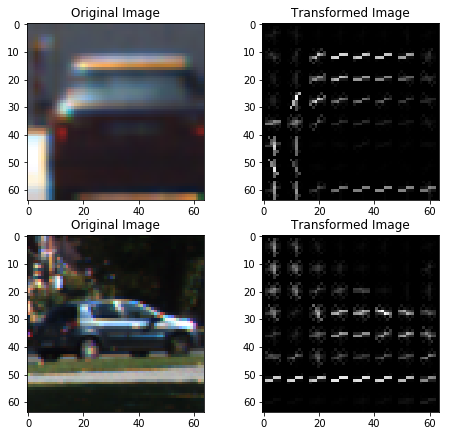

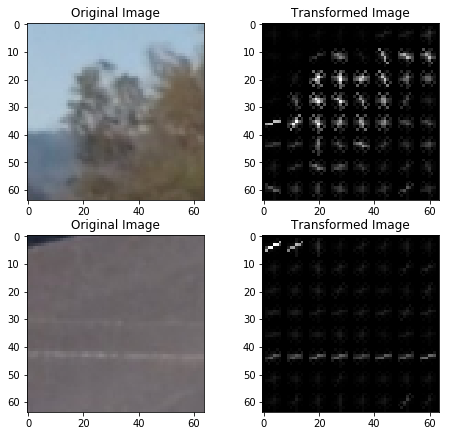

In [17]:
p_hog.set_params(
    read__input_filename=False,
    read__col_space='YCrCb',
    read__channel_nb=None,
    hog__orient=9,
    hog__output_image=True,
    hog__channel=0
    )
compare_images(2,vehicle_images,p_hog.transform,cmap_out='gray',row_size=(6,3),save_to='hog_car')
compare_images(2,non_vehicle_images,p_hog.transform,cmap_out='gray',row_size=(6,3), save_to='hog_non_car')

### b. Histogram of color - feature extraction
Similarly to HOG, we define a simple `HistoColFeatExtractor`.

In [18]:
class HistoColFeatExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, nbins=32, bins_range=(0,256)):
        self.nbins = nbins
        self.bins_range = bins_range
    
    def single_transform(self, img):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.nbins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def transform(self, x):
        return np.array([self.single_transform(f) for f in x]) if type(x) is list else self.single_transform(x)
    
    def fit(self, x, y=None):
        return self

In [19]:
p_histCol = Pipeline([
    ('read', ImageReader(col_space='RGB',channel_nb=None)),
    ('histcol',  HistoColFeatExtractor())
])

In [20]:
p_histCol.set_params(read__input_filename=True)
features = p_histCol.transform(random.sample(vehicle_images,2))
print(features, features.shape)

[[ 41 364 628 280 287 246 182 153  95  61  60  38  61 103 134 206 225 208
  204 104  61  37  26  21  18  13  17  22  14  19  20 148  70 303 516 324
  236 238 206 176 129  93  56  61  80 115 176 227 233 228 127  83  48  28
   20  24  20  20  30  23  22  29  18 137  23 270 505 400 309 198 184 160
  141 103  83  89 114 195 200 265 197 124  74  43  29  23  31  25  25  20
   21  20  19  16  30 160]
 [  0   0  91 193 180 293 283 232 310 372 347 192 107  98  68  54  73  66
   71  78  64  66  61  95  61  74  51  53  46  75  77 265   0   0   2 114
  157 180 303 295 289 307 404 377 152  84  92  79  70  66  60  78  67  71
   65  92  73  59  58  52  37  79  69 265   0   0  36 203 142 265 330 323
  420 436 263 157 115  86  73  64  66  74  74  64  72  71  97  66  54  63
   50  41  43  76  65 207]] (2, 96)


### c. Spatial binning of color - feature extraction
And for our last feature extractor, we implement the `SpatialBinningFeatExtractor`.

In [21]:
class SpatialBinningFeatExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, size=(32,32)):
        self.size = size
    
    def single_transform(self, img):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, self.size).ravel() 
        # Return the feature vector
        return features
    
    def transform(self, x):
        return np.array([self.single_transform(f) for f in x]) if type(x) is list else self.single_transform(x)
    
    def fit(self, x, y=None):
        return self

In [22]:
p_spaBin = Pipeline([
    ('read',    ImageReader(col_space='RGB',channel_nb=None)),
    ('spaBin',  SpatialBinningFeatExtractor())
])

In [23]:
p_spaBin.set_params(read__input_filename=True)
features = p_spaBin.transform(random.sample(vehicle_images,2))
print(features, features.shape)

[[139 144 141 ...,  94 101  97]
 [ 69  84 110 ..., 118 118 126]] (2, 3072)


3. Training the SVM classifier
---
Now that we have all our features, we can merge them, standardize them, and train a Support Vector Machines classifier that will recongize whether there is a car or not on a picture.

In [24]:
# Appending all images and creating labels
X = vehicle_images + non_vehicle_images
y = list(map(lambda x: 1, vehicle_images)) + list(map(lambda x: 0, non_vehicle_images))
print('X size: {} | y size: {}'.format(len(X), len(y)))

X size: 17760 | y size: 17760


In [25]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [26]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [27]:
from sklearn.calibration import CalibratedClassifierCV

p_classify = Pipeline([
    
    # Feature extraction and Union: HOG + HistoCol + SpatialBin
    ('features', FeatureUnion([
        ('HOG',   Pipeline([
            ('read',     ImageReader(col_space='YCrCb', channel_nb=None)),
            ('hog',      HOGFeatExtractor(n_jobs=10))
        ])),        
        ('histCol', Pipeline([
            ('read',     ImageReader(col_space='RGB', channel_nb=None)),
            ('histCol',  HistoColFeatExtractor(nbins=16, bins_range=(0,256)))
        ])),
        ('spaBin',  Pipeline([
            ('read',     ImageReader(col_space='RGB', channel_nb=None)),
            ('spaBin',   SpatialBinningFeatExtractor(size=(16,16)))
        ])),
    ])),
    
    # Column standardization
    ('std',      StandardScaler()),
    
    # Classification through Linear support vector machines
    # Note: we use CalibratedClassifierCV in order to get the probabilies later
    ('svc',      CalibratedClassifierCV(LinearSVC(C=0.001)))
])

Pipeline parameters:

In [28]:
p_classify.set_params(
    features__HOG__read__input_filename=True,    
    features__histCol__read__input_filename=True,
    features__spaBin__read__input_filename=True,    
);

In [29]:
p_classify.get_params();

In [30]:
%time p_classifier = p_classify.fit(X_train,y_train)

CPU times: user 45.2 s, sys: 3.83 s, total: 49.1 s
Wall time: 56.7 s


Let's check the accuracy of our classifier.

In [31]:
accuracy = p_classify.score(X_test, y_test) * 100
print('Test accuracy of SVC: {0:.1f} %'.format(accuracy))

Test accuracy of SVC: 99.4 %


4. Searching Vehicles in full images: Sliding window
---
With our classifier, we can now classify whether a car is on a 64x64 color image with **99.0% accuracy**. We need to feed our classifier with subsamples of full images actually seen by the camera(s) at the front of our car.

For this, we implement a `SlidingWindowClassifier`, which will first map a full image to a features matrix, and then draw a box if the classifier predicts that there is a car on the image.
But before that, we will need a slightly better way to get HOG features for our wider images.

In [32]:
from sklearn.base import clone
# Stateful SlidingWindowHOG class: stores the HOG features for the full image, so that requesting
# sub-images of the full image does not require to call skimage.hog
class SlidingWindowHOG:
    def __init__(self, img: np.ndarray, hog_extractor: HOGFeatExtractor):      
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        # Converting image to HLS
        img_copy = np.copy(img)
        img_copy = cv2.cvtColor( img_copy, eval('cv2.COLOR_RGB2' + 'YCrCb') )
        
        self.nblocks_per_window = (window // hog_extractor.pix_per_cell) - hog_extractor.cell_per_block + 1
        self.pix_per_cell = hog_extractor.pix_per_cell
        
        self.hog_extractor = clone(hog_extractor)
        self.hog_extractor.set_params(features_vector=False)
                
        self.hog_features  = self.hog_extractor.transform(img_copy)
        #print(self.hog_features)
        
    # For a list of subimages defined by (top_right, bottom_left), returns the np.ndarray 
    # corresponding to the HOG features
    def get_hog_features(self,subimages) -> np.ndarray:        
        return np.vstack([self.get_hog_features_for_subimage(x[0]) for x in subimages])
    
    def get_hog_features_for_subimage(self, top_left):
        xpos = top_left[0] // self.pix_per_cell
        ypos = top_left[1] // self.pix_per_cell
        #print(xpos, ypos)
        hog_feats = [h[ypos:ypos+self.nblocks_per_window, xpos:xpos+self.nblocks_per_window]
                     for h in self.hog_features]
        return np.hstack([h.ravel() for h in hog_feats])

Then we can define our `SlidingWindowClassifier`, which creates a `SlidingWindowHOG` every time a new image is passed.

_Note: Sadly, I had to break down the _`pipeline`_. :(_

In [33]:
class SlidingWindowClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, clf, x_start_stop=[None, None], y_start_stop=[None, None], 
                 scale=1, cells_per_step=2, p_threshold=0.75): 
        # If x and/or y start/stop positions not defined, set to image size
        # Compute the span of the region to be searched    
        self.x_start        = x_start_stop[0] if x_start_stop[0] else 0
        self.x_stop         = x_start_stop[1] if x_start_stop[1] else 1280
        self.y_start        = y_start_stop[0] if y_start_stop[0] else 0
        self.y_stop         = y_start_stop[1] if y_start_stop[1] else 720
        self.scale          = scale           
        self.cells_per_step = cells_per_step  # equivalent to overlap
        self.pix_per_cell   = clf.get_params()['features__HOG__hog__pix_per_cell']
        self.cell_per_block = clf.get_params()['features__HOG__hog__cell_per_block']
        
        self.clf            = clf  # This is the classifier
        self.p_threshold    = p_threshold  # Threshold probability in order to keep the windows
        
    # Takes the full image as input outputs the sub image samples
    def subsample_img(self, img):
                        
        # Define the image to search
        img_tosearch = img[self.y_start:self.y_stop, self.x_start:self.x_stop, :]
        if self.scale != 1:
            imshape = img_tosearch.shape
            img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))
        
        # Define blocks and steps as above
        nxblocks = (img_tosearch[:,:,0].shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (img_tosearch[:,:,0].shape[0] // self.pix_per_cell) - self.cell_per_block + 1
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        nxsteps = (nxblocks - nblocks_per_window) // self.cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // self.cells_per_step
        
        def get_window(x,y):
            startx = x*self.cells_per_step*self.pix_per_cell            
            starty = y*self.cells_per_step*self.pix_per_cell            
            return ((startx, starty), (startx+window, starty+window))                        
        
        def img_window_to_original_window(w):
            top_left, _ = w
            x, y        = top_left            
            x_top_left  = np.int(x*self.scale)
            y_top_left  = np.int(y*self.scale)
            win_orig    = np.int(window*self.scale)
            return ((x_top_left+self.x_start, y_top_left+self.y_start), 
                    (x_top_left+self.x_start+win_orig, y_top_left+self.y_start+win_orig))
        
        # windows in new image
        window_list = [get_window(x,y) for x in range(nxsteps) for y in range(nysteps)]
        # windows in original image
        window_list_orig = [img_window_to_original_window(w) for w in window_list]
        
        return (img_tosearch, window_list, window_list_orig,
                [img_tosearch[w[0][1]:w[0][1]+window, w[0][0]:w[0][0]+window] for w in window_list]) #window_list
    
    def transform(self, x): #returns the windows in which the classifier has spotted a car.
        img_tosearch, windows, windows_orig, subimages     = self.subsample_img(x)
        
        sw_hog      = SlidingWindowHOG(img_tosearch,self.clf.steps[0][1].transformer_list[0][1].steps[1][1])         
        hog_feats   = sw_hog.get_hog_features(windows)
     
        hist_transf = self.clf.steps[0][1].transformer_list[1][1].steps[1][1]
        hist_feats  = hist_transf.transform(subimages)  
        
        bin_transf  = self.clf.steps[0][1].transformer_list[2][1].steps[1][1]
        bin_feats   = bin_transf.transform(subimages)
 
        scaler      = self.clf.steps[1][1]
        all_feats   = scaler.transform(np.hstack((hog_feats, hist_feats, bin_feats)))
        
        svc         = self.clf.steps[2][1]        
        probas      = svc.predict_proba(all_feats)[:,1]
        
        # Returns a tuple with the original image, windows and probabilities
        return (x, 
                [w for (w,p) in zip(windows_orig, probas) if p > self.p_threshold], 
                [p for p in probas if p > self.p_threshold])
    
    def fit(self, x, y=None):
        return self

In [34]:
class BoxDrawer(BaseEstimator, TransformerMixin):
    def __init__(self, color=(0,0,255), thick=6):
        self.color = color
        self.thick = thick
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        image, windows, _ = x        
        imcopy = np.copy(image)
        # Iterate through the bounding boxes
        for bbox in windows:            
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], self.color, self.thick)
        # Return the image copy with boxes drawn
        return imcopy  

We set our previous classifier to now take images as input (not filenames anymore):

In [35]:
p_classify.set_params(       
    features__HOG__read__input_filename=False,
    features__histCol__read__input_filename=False,
    features__spaBin__read__input_filename=False
);

And then we are ready to look for car in our images!

In [36]:
test_images = glob.glob('test_images/*.jpg')

In [37]:
p_car_search = Pipeline([
    ('read',  ImageReader(col_space='RGB', channel_nb=None)),
    ('slide', SlidingWindowClassifier(p_classify, y_start_stop=[400,656], scale=2)),
    ('boxes', BoxDrawer())
]) 

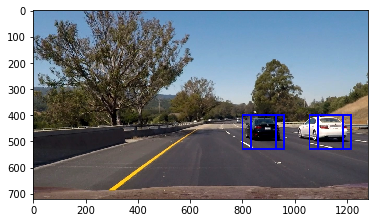

In [38]:
plt.imshow(p_car_search.transform(test_images[5]));
plt.imsave('sliding-window.png', p_car_search.transform(test_images[5]));

It looks like our pipeline is working! Now, in order to concatenate several box sizes, we need a helper Union class in the pipeline:

In [39]:
from sklearn.externals.joblib import Parallel, delayed
from sklearn.pipeline import _transform_one
class BoxUnion(FeatureUnion):
    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, name, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return []        
        else:
            img = Xs[0][0]
            Xs = (img, sum(list(map(lambda x: x[1], Xs)), []), sum(list(map(lambda x: x[2], Xs)), []))
        return Xs

In [40]:
p_car_search_multi = Pipeline([
    ('read',  ImageReader(col_space='RGB', channel_nb=None)),
    ('boxes', BoxUnion([
        ('64x64', SlidingWindowClassifier(
             p_classify, y_start_stop=[400,600], scale=1, cells_per_step=2)), 
        ('128x128', SlidingWindowClassifier(
             p_classify, y_start_stop=[400,656], scale=2, cells_per_step=1))
    ], n_jobs=1))
])
p_car_search_multi_draw = Pipeline([
    ('p_boxes', p_car_search_multi),    
    ('draw', BoxDrawer())
]) 

And then we have multiple window fits!

CPU times: user 1.66 s, sys: 977 ms, total: 2.64 s
Wall time: 1.53 s


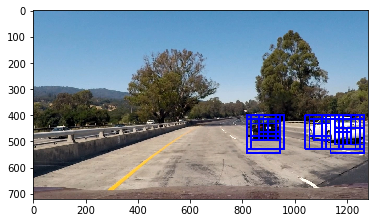

In [41]:
%time plt.imshow(p_car_search_multi_draw.transform(test_images[3]));

5. Making the classifier more robust: Heat map threshold
---
We can now leverage on our multiple `SlidingWindowClassifier`'s to create a heat map with a threshold. This is an easy way to filter our false positives on the image, such as the one below:

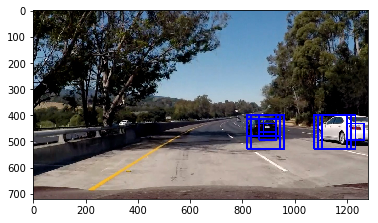

In [42]:
plt.imshow(p_car_search_multi_draw.transform(test_images[1]));

Let's create a new transformer, called `Heater`, which will convert our boxes to heat and also apply a threshold, in order to filter out zones without enough heat.

In [43]:
class Heater(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1, return_image=False):
        #self.inc = inc # increment
        self.threshold = threshold
        self.return_image = return_image # if true, returns a tuple (image, heatmap) else only heatmap
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        """
        Takes the input X: (image, boxes) and converts the boxes to heat
        """
        img, boxes, probas = X
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # Iterate through list of bboxes
        for box, proba in zip(boxes, probas):
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += proba

        # Applying threshold
        heatmap[heatmap <= self.threshold] = 0
        # Return updated heatmap
        return heatmap if not self.return_image else (img, heatmap)

This transformer now replaces the `BoxDrawer` in our previous pipeline:

In [44]:
p_car_search_and_heat = Pipeline([
    ('p_boxes', p_car_search_multi),
    ('heat',    Heater())
]) 

CPU times: user 1.66 s, sys: 820 ms, total: 2.48 s
Wall time: 1.51 s


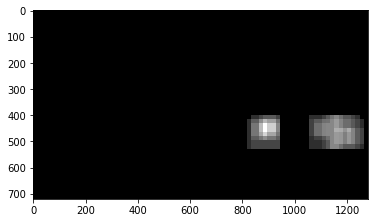

In [45]:
p_car_search_and_heat.set_params(p_boxes__read__input_filename=True, heat__return_image=False)
%time plt.imshow(p_car_search_and_heat.transform(test_images[3]),cmap='gray');

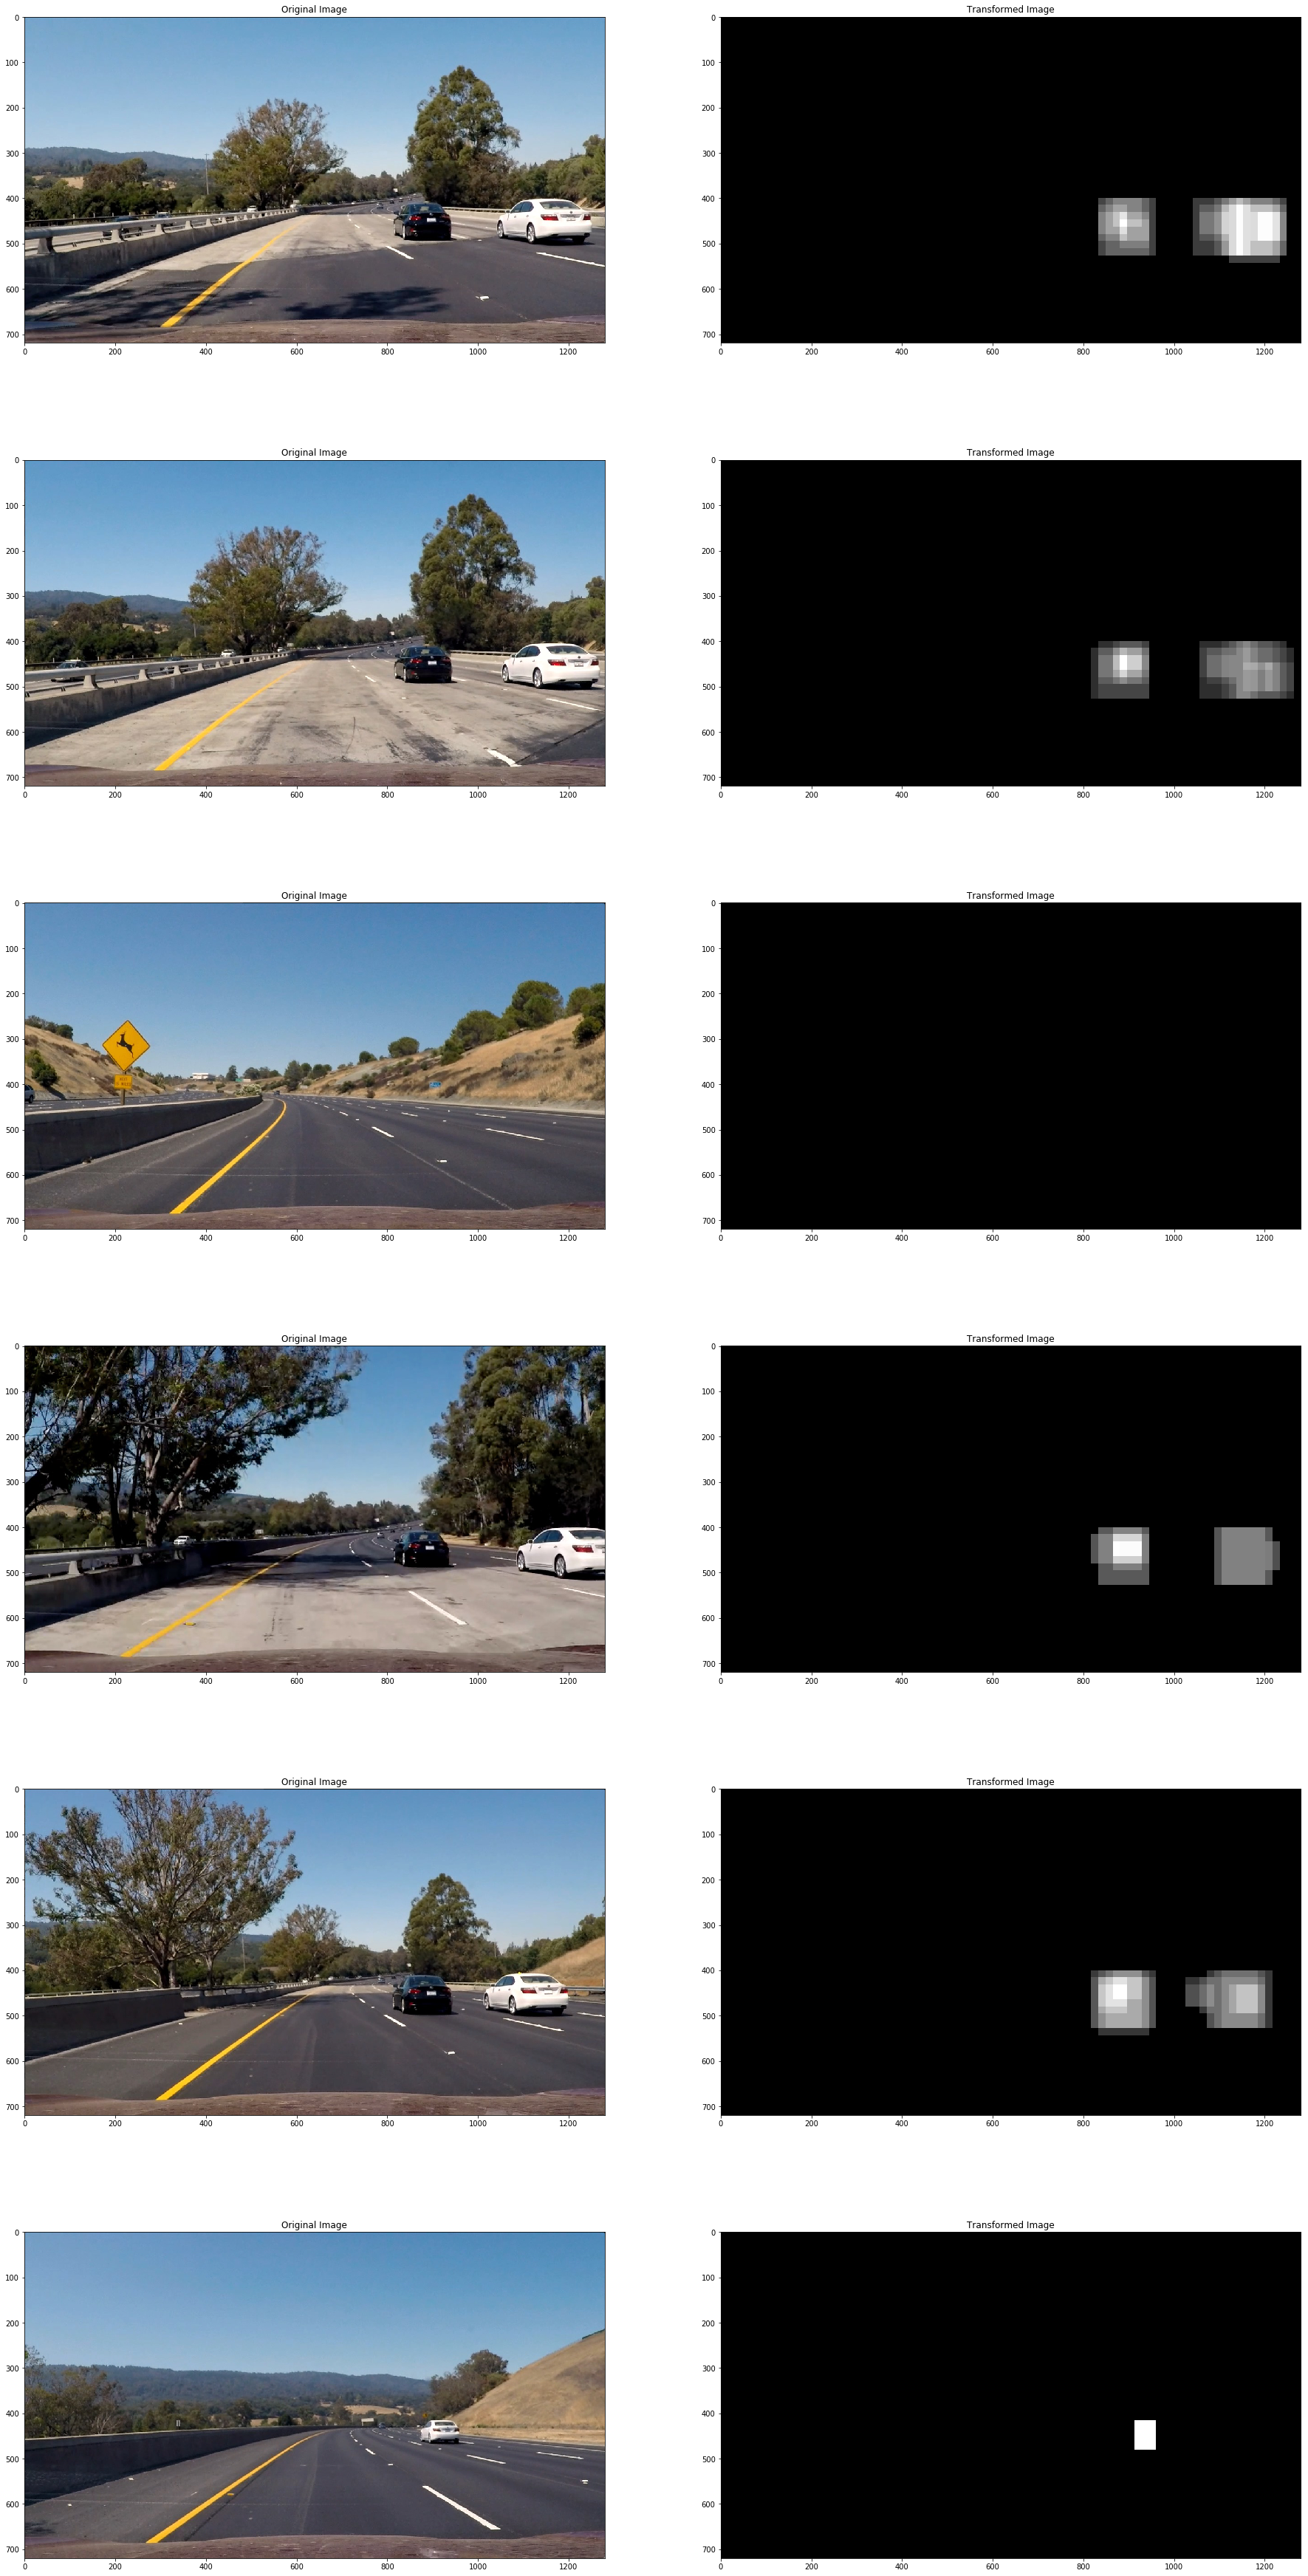

In [46]:
p_car_search_and_heat.set_params(p_boxes__read__input_filename=False, heat__return_image=False)
compare_images(6, test_images, p_car_search_and_heat.transform,cmap_out='gray', save_to='pipeline_heating')

And to finalize our pipelines, we use the `labels` function from `scipy.ndimage` in order to give labels to connected components on our heat image, we then draw a box around the identified labels.

In [47]:
from scipy.ndimage.measurements import label

class Labeler(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        image, heatmap = X
        labels = label(heatmap)
        img = np.copy(image)
        
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

We now have our full **car tracking pipeline** !

In [48]:
p_car_tracking = Pipeline([
    ('p_boxes', p_car_search_multi),
    ('heat',  Heater(threshold=1)),
    ('label', Labeler())
]) 

CPU times: user 15.3 s, sys: 5.56 s, total: 20.9 s
Wall time: 14.3 s


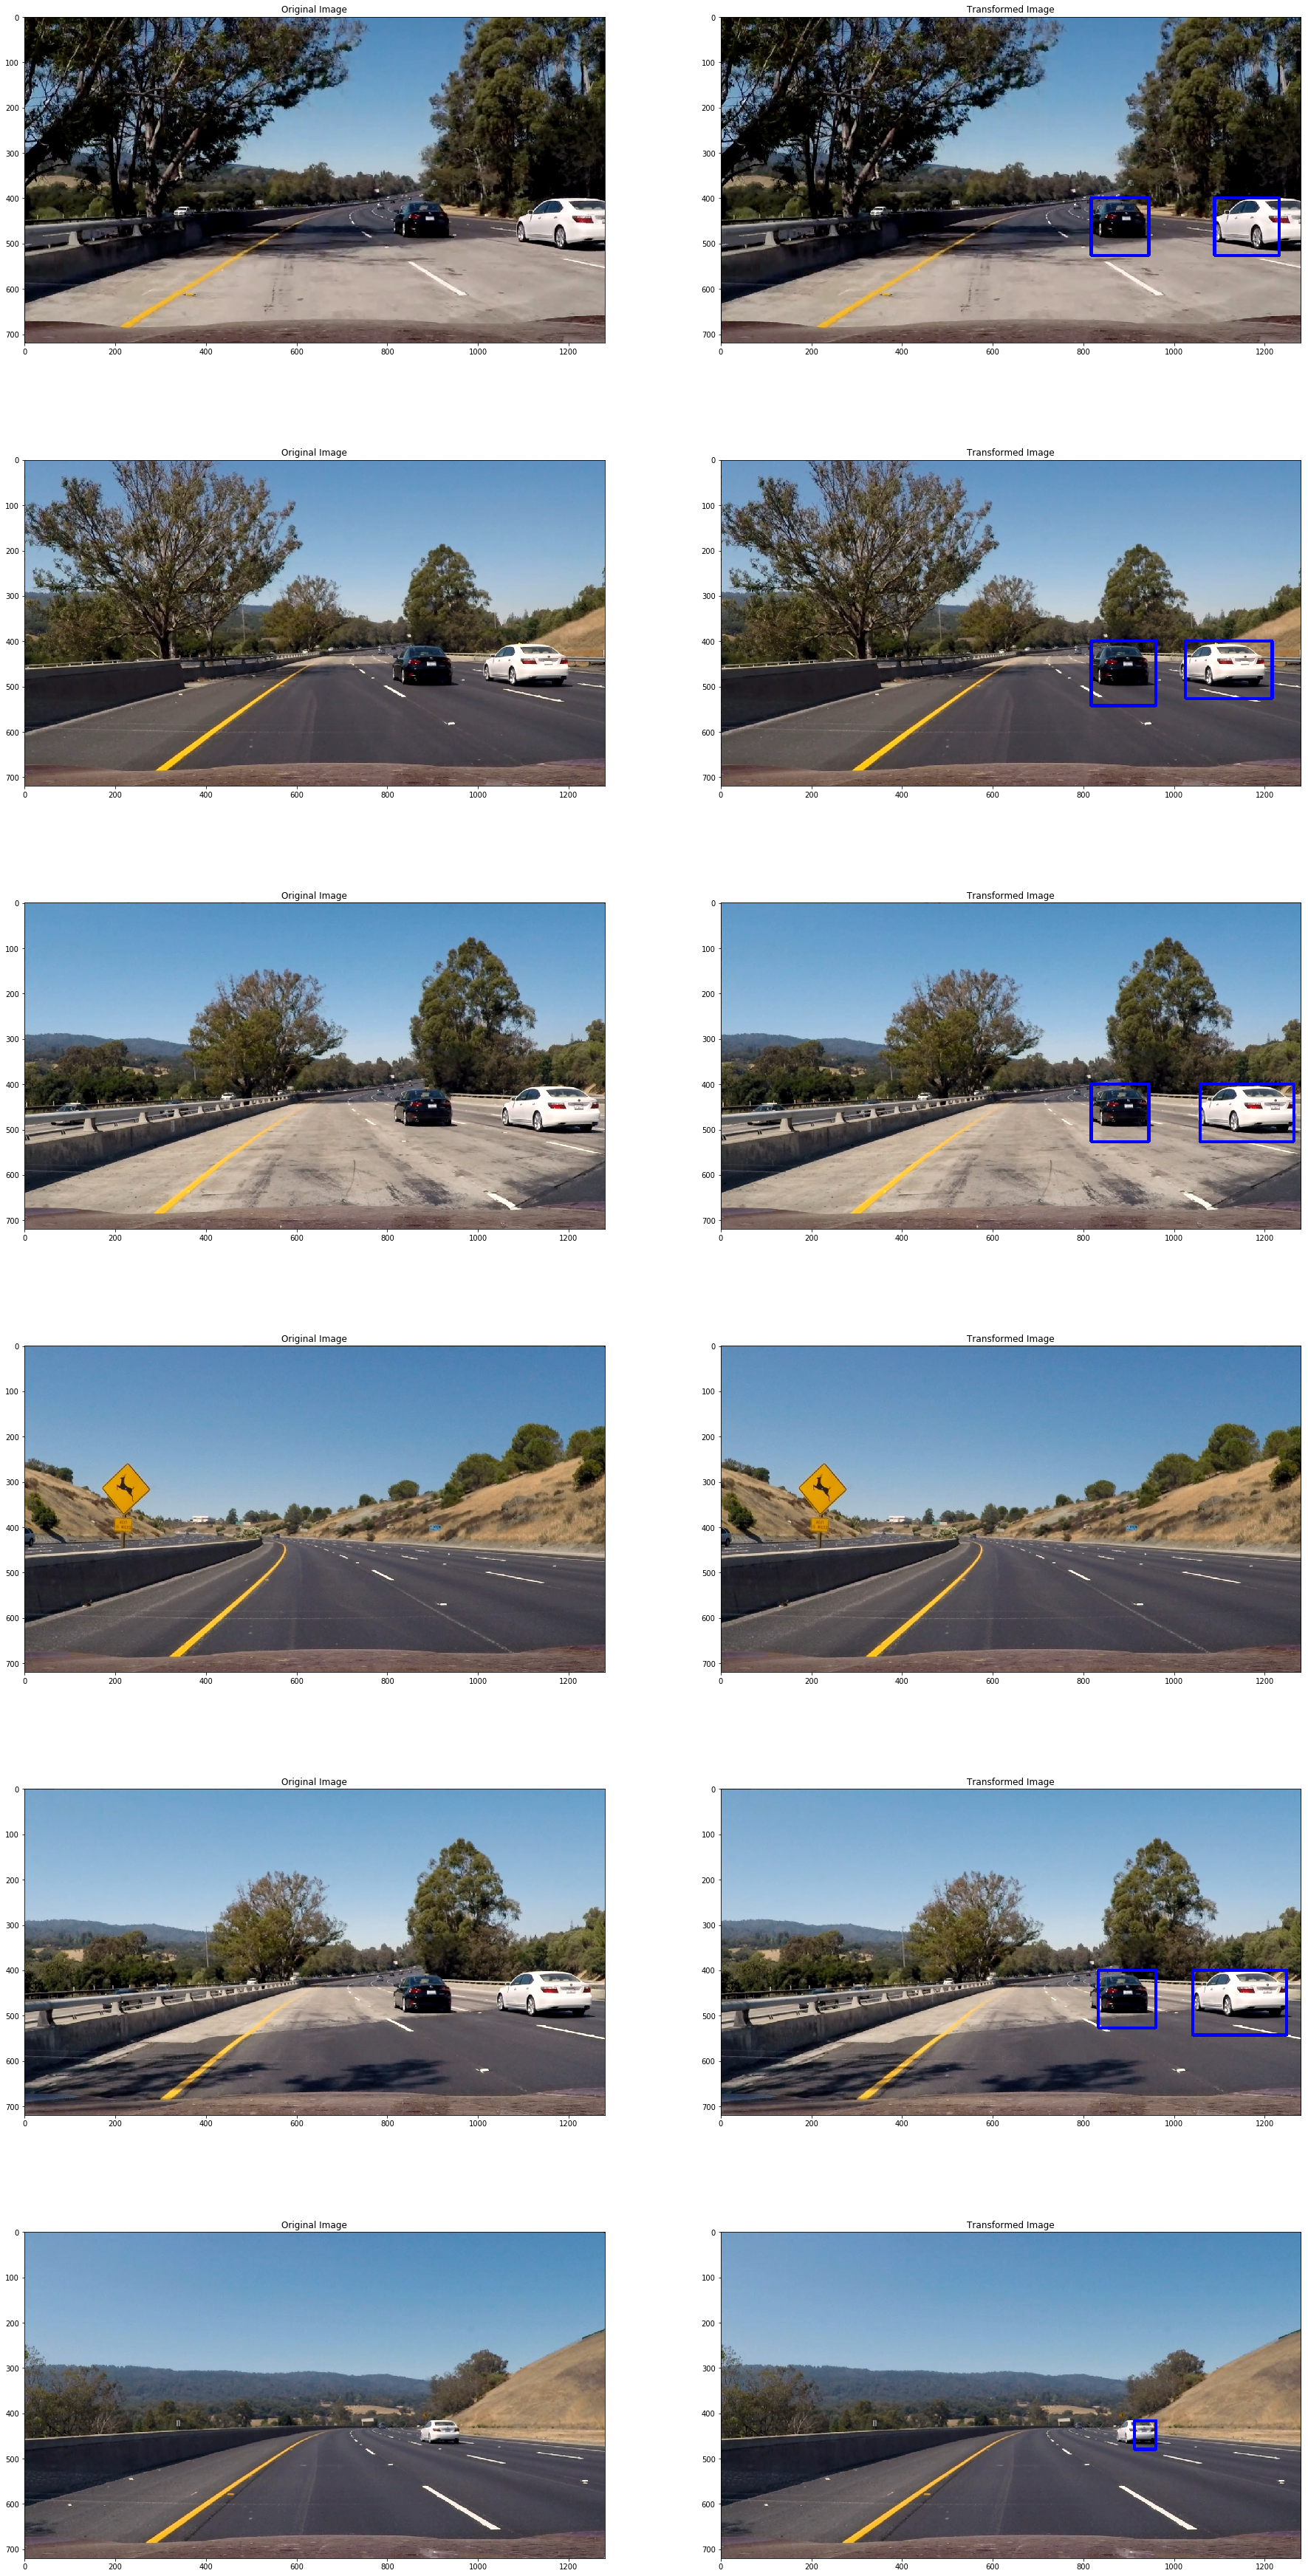

In [49]:
p_car_tracking.set_params(p_boxes__read__input_filename=False, heat__return_image=True)
%time compare_images(6, test_images, p_car_tracking.transform, save_to="pipeline_labeling")

6. Video Stream
---
Finally, since we now have a complete pipeline for single images, but we also need to add some temporal dependencies in order to work on a video stream. Let's add some state to our labeler, so that it averages the heat across several frames.

In [50]:
from scipy.ndimage.measurements import label
import collections

# The AveragingLabeler now keeps a state with the previous nb_frames and labels the average across these frames
class AveragingLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, nb_frames=10, threshold=0.4):         
        self.heat_queue = collections.deque(maxlen=nb_frames)
        self.threshold  = threshold
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        image, heatmap = X
        
        # Adding the heat map to our limited queue and computing the average heatmap
        self.heat_queue.append(heatmap)        
        avg_heatmap = sum(list(self.heat_queue)) / len(self.heat_queue)
        avg_heatmap[avg_heatmap < self.threshold] = 0
        
        labels = label(avg_heatmap)
        img = np.copy(image)
        
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

In [51]:
p_car_tracking_video = Pipeline([
    ('p_boxes', p_car_search_multi),
    ('heat',  Heater(threshold=1, return_image=True)),
    ('label', AveragingLabeler())
]) 

In [52]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_clip = VideoFileClip('test_video.mp4')
clip_with_car_detection = test_clip.fl_image(p_car_tracking_video.transform)
%time clip_with_car_detection.write_videofile('test_video_output.mp4', audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:57<00:01,  1.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 2s, sys: 30.2 s, total: 1min 32s
Wall time: 58.3 s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_output.mp4'))

In [54]:
# We need to make sure we reset the state of our AveragingLabeler
p_car_tracking_video = Pipeline([
    ('p_boxes', p_car_search_multi),
    ('heat',  Heater(threshold=1, return_image=True)),
    ('label', AveragingLabeler())
]) 

clip = VideoFileClip('project_video.mp4')
clip_with_car_detection = clip.fl_image(p_car_tracking_video.transform)
%time clip_with_car_detection.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [31:04<00:01,  1.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 33min 35s, sys: 18min 13s, total: 51min 48s
Wall time: 31min 5s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))